# Clustering Analysis

Analyze the results of clustering noisy reads to ground truth sequences using prefix indexing.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('default')
%matplotlib inline

In [2]:
# Path to clustered data
# Change this to point to your clustering output directory
clustered_dir = '/workspaces/TReconLM/data/chandak/clustered_data_edit_dist_0'

print(f"Loading clustering results from: {clustered_dir}\n")

# Load all statistics
all_stats = []

for exp_id in range(13):
    stats_file = Path(clustered_dir) / f'experiment_{exp_id}' / 'cluster_stats.json'
    
    if stats_file.exists():
        with open(stats_file, 'r') as f:
            stats = json.load(f)
            stats['exp_id'] = exp_id
            all_stats.append(stats)
        print(f"[OK] Loaded experiment_{exp_id}")
    else:
        print(f"[MISSING] experiment_{exp_id}")

print(f"\nLoaded {len(all_stats)} experiments")

Loading clustering results from: /workspaces/TReconLM/data/chandak/clustered_data_edit_dist_0

[OK] Loaded experiment_0
[OK] Loaded experiment_1
[OK] Loaded experiment_2
[OK] Loaded experiment_3
[OK] Loaded experiment_4
[OK] Loaded experiment_5
[OK] Loaded experiment_6
[OK] Loaded experiment_7
[OK] Loaded experiment_8
[OK] Loaded experiment_9
[OK] Loaded experiment_10
[OK] Loaded experiment_11
[OK] Loaded experiment_12

Loaded 13 experiments


## Summary Statistics

In [3]:
# Create summary dataframe
summary_data = []
for stats in all_stats:
    summary_data.append({
        'exp_id': stats['exp_id'],
        'total_reads': stats['total_reads'],
        'mapped': stats['num_mapped'],
        'unmapped': stats['num_unmapped'],
        'pct_mapped': stats['pct_mapped'],
        'pct_unmapped': stats['pct_unmapped'],
        'num_gt': stats['num_gt_sequences'],
        'uncovered_gts': stats['uncovered_gts'],
        'pct_uncovered': stats['pct_uncovered_gts'],
        'mean_cluster_size': stats['mean_cluster_size'],
        'std_cluster_size': stats['std_cluster_size'],
        'median_cluster_size': stats['median_cluster_size'],
        'max_cluster_size': stats['max_cluster_size']
    })

summary_df = pd.DataFrame(summary_data)

print("="*80)
print("CLUSTERING SUMMARY ACROSS ALL EXPERIMENTS")
print("="*80)
print()
print(summary_df.to_string(index=False))
print()
print("="*80)
print("TOTALS:")
print(f"  Total reads: {summary_df['total_reads'].sum():,}")
print(f"  Total mapped: {summary_df['mapped'].sum():,} ({100*summary_df['mapped'].sum()/summary_df['total_reads'].sum():.1f}%)")
print(f"  Total unmapped: {summary_df['unmapped'].sum():,} ({100*summary_df['unmapped'].sum()/summary_df['total_reads'].sum():.1f}%)")
print(f"  Total GT sequences: {summary_df['num_gt'].sum():,}")
print(f"  Total uncovered GTs: {summary_df['uncovered_gts'].sum():,}")
print("="*80)

CLUSTERING SUMMARY ACROSS ALL EXPERIMENTS

 exp_id  total_reads  mapped  unmapped  pct_mapped  pct_unmapped  num_gt  uncovered_gts  pct_uncovered  mean_cluster_size  std_cluster_size  median_cluster_size  max_cluster_size
      0       291436  108920    182516   37.373557     62.626443    1466              1       0.068213          74.297408         50.274786                 71.0             406.0
      1       253886   80387    173499   31.662636     68.337364    1466              0       0.000000          54.834243         28.006927                 53.0             194.0
      2       634914  190686    444228   30.033359     69.966641    1466              0       0.000000         130.072306         71.285231                124.0             545.0
      3       127068   48311     78757   38.019800     61.980200     815              0       0.000000          59.277301         38.211798                 54.0             263.0
      4       149622   60993     88629   40.764727     59.2352

## Cluster Size Distributions by Experiment

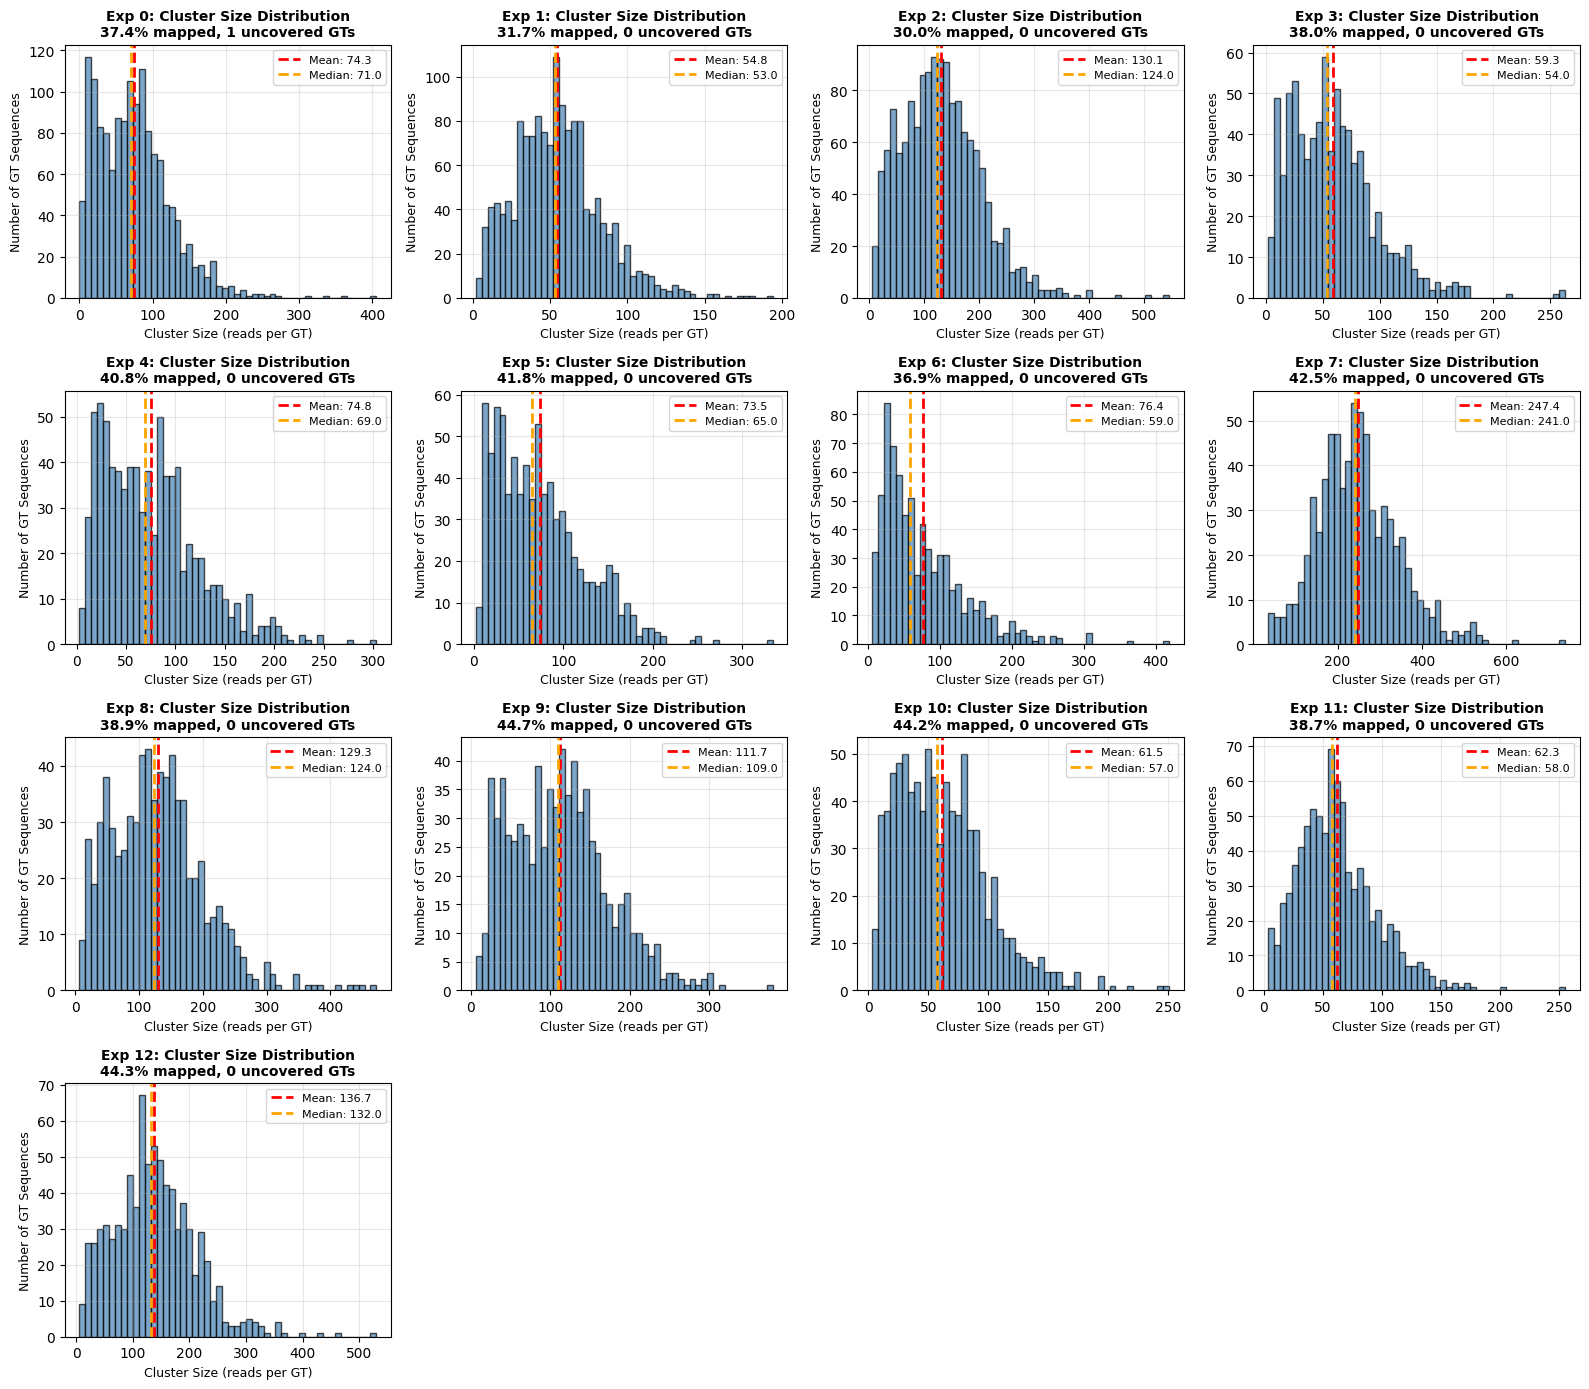

In [4]:
# Plot cluster size distributions for each experiment
fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.flatten()

for idx, stats in enumerate(all_stats):
    ax = axes[idx]
    exp_id = stats['exp_id']
    cluster_sizes = stats['cluster_sizes']
    
    # Plot histogram
    ax.hist(cluster_sizes, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(np.mean(cluster_sizes), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {np.mean(cluster_sizes):.1f}')
    ax.axvline(np.median(cluster_sizes), color='orange', linestyle='--', linewidth=2,
               label=f'Median: {np.median(cluster_sizes):.1f}')
    
    ax.set_xlabel('Cluster Size (reads per GT)', fontsize=9)
    ax.set_ylabel('Number of GT Sequences', fontsize=9)
    ax.set_title(f'Exp {exp_id}: Cluster Size Distribution\n'
                 f'{stats["pct_mapped"]:.1f}% mapped, {stats["uncovered_gts"]} uncovered GTs',
                 fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(all_stats), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Cluster Size Statistics

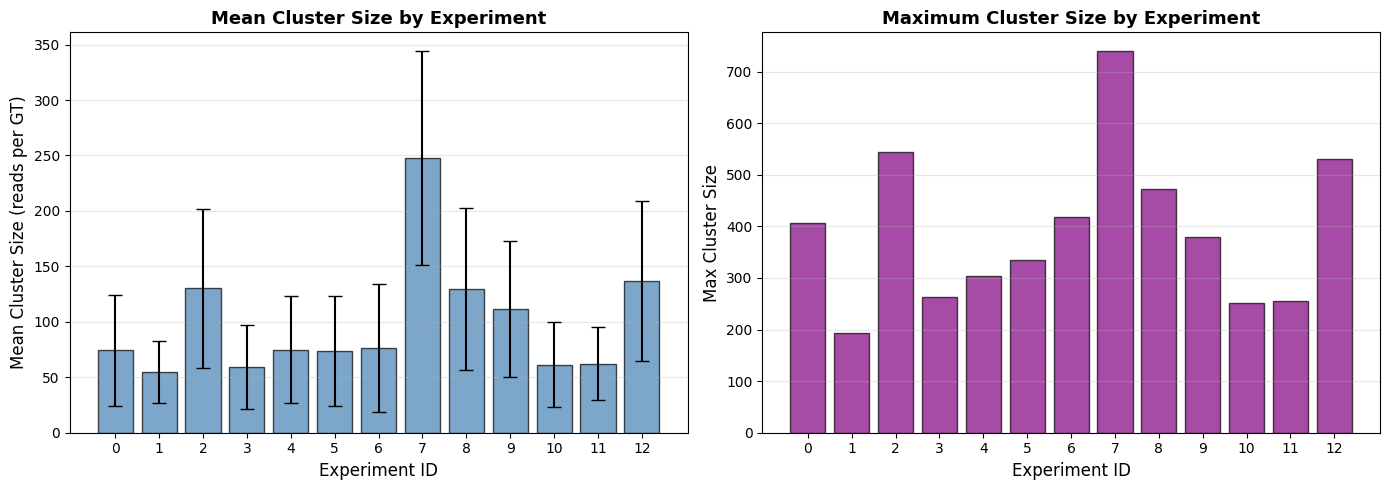

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean cluster size
ax = axes[0]
ax.bar(summary_df['exp_id'], summary_df['mean_cluster_size'],
       yerr=summary_df['std_cluster_size'],
       edgecolor='black', alpha=0.7, color='steelblue', capsize=5)

ax.set_xlabel('Experiment ID', fontsize=12)
ax.set_ylabel('Mean Cluster Size (reads per GT)', fontsize=12)
ax.set_title('Mean Cluster Size by Experiment', fontsize=13, fontweight='bold')
ax.set_xticks(range(13))
ax.grid(alpha=0.3, axis='y')

# Max cluster size
ax = axes[1]
ax.bar(summary_df['exp_id'], summary_df['max_cluster_size'],
       edgecolor='black', alpha=0.7, color='purple')

ax.set_xlabel('Experiment ID', fontsize=12)
ax.set_ylabel('Max Cluster Size', fontsize=12)
ax.set_title('Maximum Cluster Size by Experiment', fontsize=13, fontweight='bold')
ax.set_xticks(range(13))
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Detailed View: Single Experiment

DETAILED VIEW: EXPERIMENT 0
Total GT sequences: 1466
Total reads: 291,436
Mapped reads: 108,920 (37.4%)
Unmapped reads: 182,516 (62.6%)

Cluster size statistics:
  Mean: 74.30
  Median: 71.00
  Std: 50.27
  Min: 0.0
  Max: 406.0

GTs with 0 reads: 1 (0.1%)


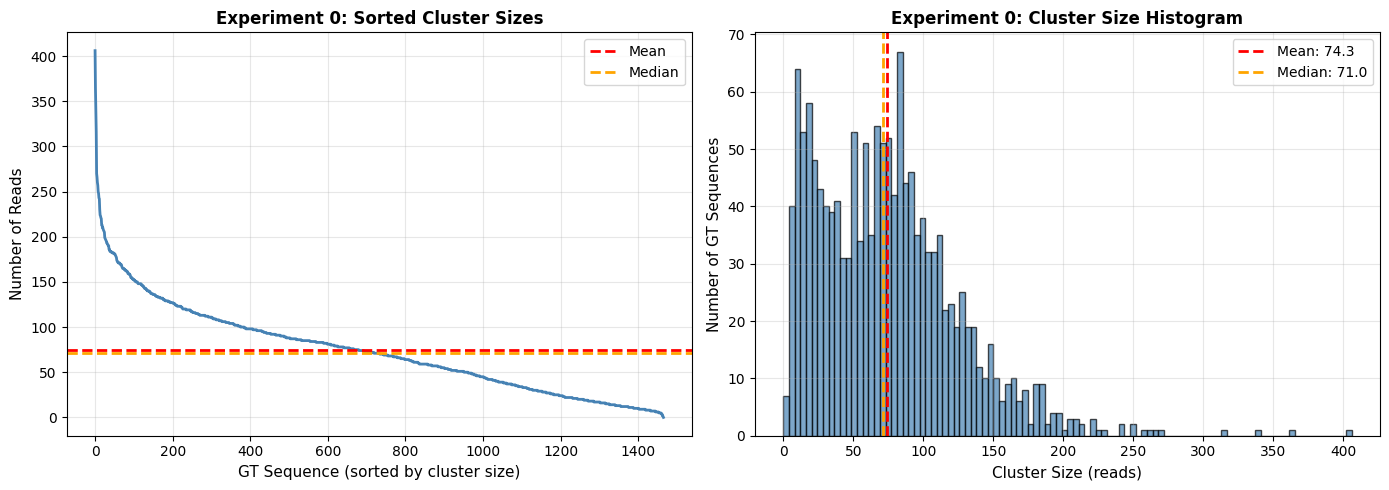

In [7]:
# Choose an experiment to examine in detail
exp_id_detailed = 0  # Change this to examine different experiments

stats = all_stats[exp_id_detailed]
cluster_sizes = np.array(stats['cluster_sizes'])

print(f"DETAILED VIEW: EXPERIMENT {exp_id_detailed}")
print("="*60)
print(f"Total GT sequences: {len(cluster_sizes)}")
print(f"Total reads: {stats['total_reads']:,}")
print(f"Mapped reads: {stats['num_mapped']:,} ({stats['pct_mapped']:.1f}%)")
print(f"Unmapped reads: {stats['num_unmapped']:,} ({stats['pct_unmapped']:.1f}%)")
print(f"\nCluster size statistics:")
print(f"  Mean: {stats['mean_cluster_size']:.2f}")
print(f"  Median: {stats['median_cluster_size']:.2f}")
print(f"  Std: {stats['std_cluster_size']:.2f}")
print(f"  Min: {stats['min_cluster_size']}")
print(f"  Max: {stats['max_cluster_size']}")
print(f"\nGTs with 0 reads: {stats['uncovered_gts']} ({stats['pct_uncovered_gts']:.1f}%)")

# Plot sorted cluster sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sorted cluster sizes
ax = axes[0]
sorted_sizes = np.sort(cluster_sizes)[::-1]  # Sort descending
ax.plot(range(len(sorted_sizes)), sorted_sizes, linewidth=2, color='steelblue')
ax.axhline(np.mean(cluster_sizes), color='red', linestyle='--', linewidth=2, label='Mean')
ax.axhline(np.median(cluster_sizes), color='orange', linestyle='--', linewidth=2, label='Median')

ax.set_xlabel('GT Sequence (sorted by cluster size)', fontsize=11)
ax.set_ylabel('Number of Reads', fontsize=11)
ax.set_title(f'Experiment {exp_id_detailed}: Sorted Cluster Sizes', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Histogram with more detail
ax = axes[1]
ax.hist(cluster_sizes, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(np.mean(cluster_sizes), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cluster_sizes):.1f}')
ax.axvline(np.median(cluster_sizes), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(cluster_sizes):.1f}')

ax.set_xlabel('Cluster Size (reads)', fontsize=11)
ax.set_ylabel('Number of GT Sequences', fontsize=11)
ax.set_title(f'Experiment {exp_id_detailed}: Cluster Size Histogram', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Load and Examine Clustering Results (optional)

In [8]:
# Load detailed clustering results for one experiment
exp_id_to_examine = 0

results_file = Path(clustered_dir) / f'experiment_{exp_id_to_examine}' / 'clustering_results.csv'
results_df = pd.read_csv(results_file)

print(f"Clustering results for experiment {exp_id_to_examine}:")
print(f"Total entries: {len(results_df):,}")
print(f"\nFirst few rows:")
print(results_df.head(10))

print(f"\nStatus distribution:")
print(results_df['status'].value_counts())

print(f"\nNumber of matches distribution:")
print(results_df['num_matches'].value_counts())

Clustering results for experiment 0:
Total entries: 291,436

First few rows:
                                         read_id  gt_idx  \
0  9c5522d5-90b7-45a7-8461-8d4814b53c01_exp0_rev     603   
1  8a6074f1-fafc-49a2-a64c-a431e25ee137_exp0_for     922   
2  1e3e4f38-d46f-4571-85d2-a6a113bbdf85_exp0_for      -1   
3  30d35c91-2f4d-4661-b441-88755a066c6c_exp0_rev      -1   
4  0baca15f-e622-4bd1-bbe1-d2ad0b0d4fec_exp0_for    1459   
5  3da77f35-3d5a-43e3-b9a3-c301146289e8_exp0_rev      -1   
6  079e5508-f05f-4c07-8415-30a9b9ddba8a_exp0_for      -1   
7  169210c6-bfa5-456f-934f-478fce269411_exp0_for    1328   
8  c42944a8-d0df-4742-b750-71f4aaf1d650_exp0_rev      -1   
9  ac32a709-67c4-4685-af8a-e9e7360f34cd_exp0_rev      58   

                                               gt_id  match_pos  edit_dist  \
0  oligos_0_CTGGCTCCTCTGTATGTTGGAGAAT_CCTATATGTAC...          0          0   
1  oligos_0_CTGGCTCCTCTGTATGTTGGAGAAT_CCTATATGTAC...          0          0   
2                           